In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
from torch.autograd.functional import hessian, jacobian
from torch.autograd import grad



class PINN(nn.Module):
    def __init__(self, hidden_layers=[20, 20]):
        super().__init__()
        
        # Input layer: (x, t) -> first hidden layer
        layers = [nn.Linear(2, hidden_layers[0]), nn.Tanh()]
        
        # Hidden layers
        for i in range(len(hidden_layers)-1):
            layers.extend([
                nn.Linear(hidden_layers[i], hidden_layers[i+1]),
                nn.Tanh()
            ])
            
        # Output layer
        layers.append(nn.Linear(hidden_layers[-1], 1))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.network(inputs)
    
    def compute_derivatives(self, x, t):
        # Create variables requiring gradient
        x = x.requires_grad_(True)
        t = t.requires_grad_(True)
        
        # Forward pass
        u = self.forward(x, t)
        
        # First derivatives
        du_dt = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        
        du_dx = torch.autograd.grad(
            u, x,
            grad_outputs=torch.ones_like(u),
            create_graph=True
        )[0]
        
        # Second derivative
        d2u_dx2 = torch.autograd.grad(
            du_dx, x,
            grad_outputs=torch.ones_like(du_dx),
            create_graph=True
        )[0]
        
        return du_dt, du_dx, d2u_dx2

def generate_training_data(device, n_points=1000):
    # Generate collocation points
    x = torch.linspace(0, 1, n_points).reshape(-1, 1).to(device)
    t = torch.linspace(0, 1, n_points).reshape(-1, 1).to(device)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze())
    x_train = X.reshape(-1, 1).to(device)
    t_train = T.reshape(-1, 1).to(device)
    
    # Generate boundary and initial conditions
    x_ic = torch.linspace(0, 1, n_points//10).reshape(-1, 1).to(device)
    t_ic = torch.zeros_like(x_ic).to(device)
    u_ic = torch.sin(np.pi * x_ic).to(device)  # Initial condition: u(x,0) = sin(πx)
    
    return x_train, t_train, x_ic, t_ic, u_ic

def train_pinn(model, device, n_epochs=5000):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    mse_loss = nn.MSELoss()
    
    # Generate training data
    x_train, t_train, x_ic, t_ic, u_ic = generate_training_data(device)
    # Training history
    history = {
        'total_loss': [],
        'physics_loss': [],
        'data_loss': [],
        'hessian_metrics': []
    }
    # Training loop
    for epoch in tqdm.tqdm(range(n_epochs)):
        optimizer.zero_grad()
        
        # Compute PDE residual
        du_dt, du_dx, d2u_dx2 = model.compute_derivatives(x_train, t_train)
        pde_residual = du_dt - 0.01 * d2u_dx2  # Heat equation: ∂u/∂t = α∂²u/∂x²
        
        # Compute initial condition residual
        u_pred_ic = model(x_ic, t_ic)
        ic_residual = u_pred_ic - u_ic
        
        # Total loss
        l1 = mse_loss(pde_residual, torch.zeros_like(pde_residual))
        l2 = mse_loss(ic_residual, torch.zeros_like(ic_residual))
        loss = l1 + l2
               
        history['total_loss'].append(loss.item())
        history['physics_loss'].append(l1.item())
        history['data_loss'].append(l2.item())
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 500 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss.item():.6f}')

        if (epoch + 1) % 5 == 0:
            # print(f'\nEpoch {epoch+1}, Loss: {avg_epoch_loss:.6f}')
            # Move small batch to CPU for Hessian computation
            x_small = x_train
            t_small = t_train
            H = compute_full_hessian(model, x_small, t_small)
            print(H)
            analysis = analyze_hessian(H)
            history['hessian_metrics'].append(analysis)
            print("Hessian condition number:", analysis['condition_number'])
    
    return history

def plot_solution(model, device):
    x = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
    t = torch.linspace(0, 1, 100).reshape(-1, 1).to(device)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze())
    
    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)
    
    with torch.no_grad():
        u_pred = model(X_flat, T_flat).reshape(X.shape).cpu()
    
    plt.figure(figsize=(10, 8))
    plt.contourf(X.cpu(), T.cpu(), u_pred.numpy(), levels=50)
    plt.colorbar(label='u(x,t)')
    plt.xlabel('x')
    plt.ylabel('t')
    plt.title('PINN Solution of Heat Equation')
    plt.show()

def compute_loss(model, x, t, u_true=None):
    """Compute the PINN loss for Hessian calculation"""
    x = x.to(device)
    t = t.to(device)
    x.requires_grad_(True)
    t.requires_grad_(True)
    
    u = model(x, t)
    
    # First derivatives
    du_dt = grad(u.sum(), t, create_graph=True)[0]
    du_dx = grad(u.sum(), x, create_graph=True)[0]
    
    # Second derivative
    d2u_dx2 = grad(du_dx.sum(), x, create_graph=True)[0]
    
    # PDE residual (heat equation)
    pde_residual = du_dt - 0.01 * d2u_dx2
    
    # Loss computation
    if u_true is not None:
        u_true = u_true.to(device)
        data_loss = torch.mean((u - u_true)**2)
    else:
        data_loss = torch.tensor(0.0).to(device)
    
    physics_loss = torch.mean(pde_residual**2)
    total_loss = data_loss + physics_loss
    
    return total_loss, physics_loss, data_loss

def compute_full_hessian(model, x, t, u_true=None):
    """Compute the full Hessian matrix with respect to all parameters"""
    # Note: Hessian computation is done on CPU due to memory constraints
    def loss_closure():
        return compute_loss(model, x, t, u_true)[0]
    
    params = [p for p in model.parameters()]
    n_params = sum(p.numel() for p in params)
    
    def get_params_vector():
        return torch.cat([p.view(-1) for p in model.parameters()])
    
    def loss_from_params(params_vector):
        offset = 0
        for param in model.parameters():
            param_shape = param.shape
            param_size = param.numel()
            param.data = params_vector[offset:offset + param_size].view(param_shape)
            offset += param_size
        return loss_closure()
    
    params_vector = get_params_vector()
    H = hessian(loss_from_params, params_vector)
    
    return H

def analyze_hessian(H):
    """Analyze properties of the Hessian matrix"""
    H_np = H.cpu().detach().numpy()
    eigenvalues = np.linalg.eigvalsh(H_np)
    
    condition_number = np.abs(eigenvalues[-1] / eigenvalues[0])
    trace = np.trace(H_np)
    try:
        determinant = np.linalg.det(H_np)
    except:
        determinant = float('inf')
    
    return {
        'max_eigenvalue': float(eigenvalues[-1]),
        'min_eigenvalue': float(eigenvalues[0]),
        'condition_number': float(condition_number),
        'trace': float(trace),
        'determinant': float(determinant),
        'eigenvalue_distribution': eigenvalues
    }

def plot_training_history(history):
    """Plot training losses and Hessian metrics"""
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.semilogy(history['total_loss'], label='Total Loss')
    plt.semilogy(history['physics_loss'], label='Physics Loss')
    plt.semilogy(history['data_loss'], label='Data Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')
    
    # Plot condition number
    plt.subplot(1, 2, 2)
    condition_numbers = [metrics['condition_number'] for metrics in history['hessian_metrics']]
    plt.semilogy(range(0, len(history['total_loss']), len(history['total_loss'])//len(condition_numbers)), 
                condition_numbers)
    plt.xlabel('Epoch')
    plt.ylabel('Condition Number')
    plt.title('Hessian Condition Number')
    
    plt.tight_layout()
    plt.show()


# Main execution
    # Create and train the model


In [ ]:
device = torch.device('cuda')
model = PINN().to(device)

history = train_pinn(model, device)
# plot_solution(model)

In [ ]:
plot_solution(model, device)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd.functional import hessian, jacobian
from torch.autograd import grad
from tqdm import tqdm

# Check for CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class HessianPINN(nn.Module):
    def __init__(self, hidden_layers=[20, 20, 20]):
        super().__init__()
        layers = [nn.Linear(2, hidden_layers[0]), nn.Tanh()]
        for i in range(len(hidden_layers)-1):
            layers.extend([
                nn.Linear(hidden_layers[i], hidden_layers[i+1]),
                nn.Tanh()
            ])
        layers.append(nn.Linear(hidden_layers[-1], 1))
        self.network = nn.Sequential(*layers)
        self.to(device)  # Move model to GPU
        
    def forward(self, x, t):
        inputs = torch.cat([x, t], dim=1)
        return self.network(inputs)

def compute_loss(model, x, t, u_true=None):
    """Compute the PINN loss for Hessian calculation"""
    x = x.to(device)
    t = t.to(device)
    x.requires_grad_(True)
    t.requires_grad_(True)
    
    u = model(x, t)
    
    # First derivatives
    du_dt = grad(u.sum(), t, create_graph=True)[0]
    du_dx = grad(u.sum(), x, create_graph=True)[0]
    
    # Second derivative
    d2u_dx2 = grad(du_dx.sum(), x, create_graph=True)[0]
    
    # PDE residual (heat equation)
    pde_residual = du_dt - 0.01 * d2u_dx2
    
    # Loss computation
    if u_true is not None:
        u_true = u_true.to(device)
        data_loss = torch.mean((u - u_true)**2)
    else:
        data_loss = torch.tensor(0.0).to(device)
    
    physics_loss = torch.mean(pde_residual**2)
    total_loss = data_loss + physics_loss
    
    return total_loss, physics_loss, data_loss

def generate_training_data(n_points=1000):
    """Generate training data including boundary and initial conditions"""
    # Generate collocation points
    x = torch.linspace(0, 1, n_points, device=device).reshape(-1, 1)
    t = torch.linspace(0, 1, n_points, device=device).reshape(-1, 1)
    X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')
    x_train = X.reshape(-1, 1)
    t_train = T.reshape(-1, 1)
    
    # Generate initial conditions
    x_ic = torch.linspace(0, 1, n_points//10, device=device).reshape(-1, 1)
    t_ic = torch.zeros_like(x_ic)
    u_ic = torch.sin(np.pi * x_ic)
    
    # Generate boundary conditions
    t_bc = torch.linspace(0, 1, n_points//10, device=device).reshape(-1, 1)
    x_bc_0 = torch.zeros_like(t_bc)
    x_bc_1 = torch.ones_like(t_bc)
    
    return {
        'collocation': (x_train, t_train),
        'initial': (x_ic, t_ic, u_ic),
        'boundary': (x_bc_0, x_bc_1, t_bc)
    }

def train_hessian_pinn(model, n_epochs=5000, batch_size=1000, compute_hessian_freq=1000):
    """Train the PINN with periodic Hessian analysis"""
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, verbose=True)
    
    # Generate training data
    data = generate_training_data()
    x_train, t_train = data['collocation']
    x_ic, t_ic, u_ic = data['initial']
    x_bc_0, x_bc_1, t_bc = data['boundary']
    
    # Move all data to GPU
    x_train, t_train = x_train.to(device), t_train.to(device)
    x_ic, t_ic, u_ic = x_ic.to(device), t_ic.to(device), u_ic.to(device)
    x_bc_0, x_bc_1, t_bc = x_bc_0.to(device), x_bc_1.to(device), t_bc.to(device)
    
    n_train = x_train.shape[0]
    n_batches = n_train // batch_size
    
    # Training history
    history = {
        'total_loss': [],
        'physics_loss': [],
        'data_loss': [],
        'hessian_metrics': []
    }
    
    # Training loop
    for epoch in tqdm(range(n_epochs)):
        # Shuffle training data
        idx = torch.randperm(n_train, device=device)
        x_train = x_train[idx]
        t_train = t_train[idx]
        
        epoch_loss = 0
        for batch in range(n_batches):
            optimizer.zero_grad()
            
            # Get batch data
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            x_batch = x_train[start_idx:end_idx]
            t_batch = t_train[start_idx:end_idx]
            
            # Compute losses
            total_loss, physics_loss, data_loss = compute_loss(model, x_batch, t_batch)
            
            # Add initial condition loss
            u_pred_ic = model(x_ic, t_ic)
            ic_loss = torch.mean((u_pred_ic - u_ic)**2)
            
            # Add boundary condition loss (u(0,t) = u(1,t) = 0)
            u_bc_0 = model(x_bc_0, t_bc)
            u_bc_1 = model(x_bc_1, t_bc)
            bc_loss = torch.mean(u_bc_0**2 + u_bc_1**2)
            
            # Total loss
            loss = total_loss + ic_loss + bc_loss
            
            # Backpropagation
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            
        avg_epoch_loss = epoch_loss / n_batches
        scheduler.step(avg_epoch_loss)
        
        # Store losses
        history['total_loss'].append(avg_epoch_loss)
        history['physics_loss'].append(physics_loss.item())
        history['data_loss'].append(data_loss.item())
        
        # Compute Hessian periodically
        if (epoch + 1) % compute_hessian_freq == 0:
            print(f'\nEpoch {epoch+1}, Loss: {avg_epoch_loss:.6f}')
            # Move small batch to CPU for Hessian computation
            x_small = x_batch[:10].cpu()
            t_small = t_batch[:10].cpu()
            model.cpu()
            H = compute_full_hessian(model, x_small, t_small)
            print(H)
            model.to(device)  # Move model back to GPU
            analysis = analyze_hessian(H)
            history['hessian_metrics'].append(analysis)
            print("Hessian condition number:", analysis['condition_number'])
    
    return history

def compute_full_hessian(model, x, t, u_true=None):
    """Compute the full Hessian matrix with respect to all parameters"""
    # Note: Hessian computation is done on CPU due to memory constraints
    def loss_closure():
        return compute_loss(model, x, t, u_true)[0]
    
    params = [p for p in model.parameters()]
    n_params = sum(p.numel() for p in params)
    
    def get_params_vector():
        return torch.cat([p.view(-1) for p in model.parameters()])
    
    def loss_from_params(params_vector):
        offset = 0
        for param in model.parameters():
            param_shape = param.shape
            param_size = param.numel()
            param.data = params_vector[offset:offset + param_size].view(param_shape)
            offset += param_size
        return loss_closure()
    
    params_vector = get_params_vector()
    H = hessian(loss_from_params, params_vector)
    
    return H

def analyze_hessian(H):
    """Analyze properties of the Hessian matrix"""
    H_np = H.detach().numpy()
    eigenvalues = np.linalg.eigvalsh(H_np)
    
    condition_number = np.abs(eigenvalues[-1] / eigenvalues[0])
    trace = np.trace(H_np)
    try:
        determinant = np.linalg.det(H_np)
    except:
        determinant = float('inf')
    
    return {
        'max_eigenvalue': float(eigenvalues[-1]),
        'min_eigenvalue': float(eigenvalues[0]),
        'condition_number': float(condition_number),
        'trace': float(trace),
        'determinant': float(determinant),
        'eigenvalue_distribution': eigenvalues
    }

def plot_training_history(history):
    """Plot training losses and Hessian metrics"""
    plt.figure(figsize=(15, 5))
    
    # Plot losses
    plt.subplot(1, 2, 1)
    plt.semilogy(history['total_loss'], label='Total Loss')
    plt.semilogy(history['physics_loss'], label='Physics Loss')
    plt.semilogy(history['data_loss'], label='Data Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training Losses')
    
    # Plot condition number
    plt.subplot(1, 2, 2)
    condition_numbers = [metrics['condition_number'] for metrics in history['hessian_metrics']]
    plt.semilogy(range(0, len(history['total_loss']), len(history['total_loss'])//len(condition_numbers)), 
                condition_numbers)
    plt.xlabel('Epoch')
    plt.ylabel('Condition Number')
    plt.title('Hessian Condition Number')
    
    plt.tight_layout()
    plt.show()

# def main():
    # Set random seed for reproducibility


In [ ]:
device = torch.device('cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Create and train model
model = HessianPINN(hidden_layers=[20, 20, 20]).to(device)
history = train_hessian_pinn(model, n_epochs=5000, compute_hessian_freq=1)

# Plot training results
plot_training_history(history)

# Final Hessian analysis
model.cpu()  # Move model to CPU for final Hessian computation
x = torch.linspace(0, 1, 10).reshape(-1, 1).requires_grad_(True)
t = torch.linspace(0, 1, 10).reshape(-1, 1).requires_grad_(True)
H = compute_full_hessian(model, x, t)
analysis = analyze_hessian(H)
print("\nFinal Hessian Analysis:")
for key, value in analysis.items():
    if key != 'eigenvalue_distribution':
        print(f"{key}: {value}")



In [ ]:
def compute_full_hessian(model, x, t, u_true=None):
    """Compute the full Hessian matrix with respect to all parameters"""
    # Move data to CPU for Hessian computation
    x = x.cpu().requires_grad_(True)
    t = t.cpu().requires_grad_(True)
    model = model.cpu()
    
    # Get original parameters
    original_params = [p.clone().detach() for p in model.parameters()]
    
    def get_loss(flat_params):
        # Restore parameters to their vector form
        offset = 0
        for param in model.parameters():
            num_params = param.numel()
            param.data = flat_params[offset:offset + num_params].view(param.size())
            offset += num_params
            
        # Compute forward pass and loss
        u = model(x, t)
        
        # First derivatives
        du_dt = grad(u.sum(), t, create_graph=True)[0]
        du_dx = grad(u.sum(), x, create_graph=True)[0]
        
        # Second derivative
        d2u_dx2 = grad(du_dx.sum(), x, create_graph=True)[0]
        
        # PDE residual (heat equation)
        pde_residual = du_dt - 0.01 * d2u_dx2
        
        # Compute total loss
        loss = torch.mean(pde_residual**2)
        
        if u_true is not None:
            u_true = u_true.cpu()
            loss += torch.mean((u - u_true)**2)
        
        return loss
    
    # Get flat parameters
    flat_params = torch.cat([p.flatten() for p in model.parameters()])
    flat_params.requires_grad_(True)
    
    # Compute Hessian using autograd.functional
    H = hessian(get_loss, flat_params)
    
    # Restore original parameters
    for param, orig_param in zip(model.parameters(), original_params):
        param.data = orig_param.data
    
    return H

def analyze_hessian(H):
    """Analyze properties of the Hessian matrix"""
    H_np = H.detach().numpy()
    
    # Add small diagonal term for numerical stability
    H_np = H_np + np.eye(H_np.shape[0]) * 1e-6
    
    try:
        eigenvalues = np.linalg.eigvalsh(H_np)
        condition_number = np.abs(eigenvalues[-1] / eigenvalues[0])
        trace = np.trace(H_np)
        
        # Compute determinant safely
        sign, logdet = np.linalg.slogdet(H_np)
        determinant = sign * np.exp(logdet) if np.isfinite(logdet) else float('inf')
        
        return {
            'max_eigenvalue': float(eigenvalues[-1]),
            'min_eigenvalue': float(eigenvalues[0]),
            'condition_number': float(condition_number),
            'trace': float(trace),
            'determinant': float(determinant),
            'eigenvalue_distribution': eigenvalues
        }
    except np.linalg.LinAlgError:
        print("Warning: Linear algebra error in Hessian analysis")
        return {
            'max_eigenvalue': float('nan'),
            'min_eigenvalue': float('nan'),
            'condition_number': float('nan'),
            'trace': float(np.trace(H_np)),
            'determinant': float('nan'),
            'eigenvalue_distribution': np.array([])
        }

def train_hessian_pinn(model, n_epochs=5000, batch_size=100, compute_hessian_freq=500):
    """Train the PINN with periodic Hessian analysis"""
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5, verbose=True)
    
    # Generate training data
    data = generate_training_data()
    x_train, t_train = data['collocation']
    x_ic, t_ic, u_ic = data['initial']
    x_bc_0, x_bc_1, t_bc = data['boundary']
    
    n_train = x_train.shape[0]
    n_batches = n_train // batch_size
    
    history = {
        'total_loss': [],
        'physics_loss': [],
        'data_loss': [],
        'hessian_metrics': []
    }
    
    for epoch in tqdm(range(n_epochs)):
        idx = torch.randperm(n_train, device=device)
        x_train = x_train[idx]
        t_train = t_train[idx]
        
        epoch_loss = 0
        for batch in range(n_batches):
            optimizer.zero_grad()
            
            start_idx = batch * batch_size
            end_idx = start_idx + batch_size
            x_batch = x_train[start_idx:end_idx]
            t_batch = t_train[start_idx:end_idx]
            
            total_loss, physics_loss, data_loss = compute_loss(model, x_batch, t_batch)
            
            u_pred_ic = model(x_ic, t_ic)
            ic_loss = torch.mean((u_pred_ic - u_ic)**2)
            
            u_bc_0 = model(x_bc_0, t_bc)
            u_bc_1 = model(x_bc_1, t_bc)
            bc_loss = torch.mean(u_bc_0**2 + u_bc_1**2)
            
            loss = total_loss + ic_loss + bc_loss
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_epoch_loss = epoch_loss / n_batches
        scheduler.step(avg_epoch_loss)
        
        history['total_loss'].append(avg_epoch_loss)
        history['physics_loss'].append(physics_loss.item())
        history['data_loss'].append(data_loss.item())
        
        if (epoch + 1) % compute_hessian_freq == 0:
            print(f'\nEpoch {epoch+1}, Loss: {avg_epoch_loss:.6f}')
            
            # Compute Hessian on a small batch
            x_small = x_batch[:5].clone()  # Using smaller batch for Hessian
            t_small = t_batch[:5].clone()
            
            # Ensure we're computing gradients
            with torch.set_grad_enabled(True):
                H = compute_full_hessian(model, x_small, t_small)
                analysis = analyze_hessian(H)
                history['hessian_metrics'].append(analysis)
                print("Hessian Analysis:")
                print(f"Condition Number: {analysis['condition_number']:.2e}")
                print(f"Max Eigenvalue: {analysis['max_eigenvalue']:.2e}")
                print(f"Min Eigenvalue: {analysis['min_eigenvalue']:.2e}")
            
            # Move model back to GPU
            model.to(device)
    
    return history

In [ ]:
# Test Hessian computation
x_test = torch.linspace(0, 1, 5).reshape(-1, 1).requires_grad_(True)
t_test = torch.linspace(0, 1, 5).reshape(-1, 1).requires_grad_(True)
H = compute_full_hessian(model, x_test, t_test)
print("Hessian shape:", H.shape)
print("Hessian sum:", H.sum().item())
print("Hessian max:", H.max().item())
print("Hessian min:", H.min().item())

In [66]:
import torch
from torch.autograd import grad
import torch.nn as nn

def compute_hessian(model: nn.Module, loss_fn, data_points, labels=None):
    """
    Compute the Hessian matrix of the loss with respect to model parameters.
    
    Args:
        model (nn.Module): The neural network model
        loss_fn: Loss function that takes model output (and optionally labels) as input
        data_points (torch.Tensor): Input data points
        labels (torch.Tensor, optional): Labels for supervised learning tasks
    
    Returns:
        torch.Tensor: Hessian matrix of shape (num_parameters, num_parameters)
    """
    # Get model parameters and their total count
    parameters = list(model.parameters())
    n_params = sum(p.numel() for p in parameters)
    
    # Flatten parameters for easier handling
    def get_params_vector():
        return torch.cat([p.flatten() for p in parameters])
    
    # Function to compute loss and gradients
    def get_loss_and_grad():
        # Forward pass
        outputs = model(data_points)
        
        # Compute loss
        if labels is not None:
            loss = loss_fn(outputs, labels)
        else:
            loss = loss_fn(outputs)
            
        # Compute gradients
        gradients = grad(loss, parameters, create_graph=True)
        grad_vector = torch.cat([g.flatten() for g in gradients])
        
        return loss, grad_vector
    
    # Initialize Hessian matrix
    hessian = torch.zeros(n_params, n_params)
    
    # Compute loss and first-order gradients
    loss, gradients = get_loss_and_grad()
    
    # Compute second-order derivatives
    for i in range(n_params):
        # Compute derivative of i-th gradient component with respect to all parameters
        second_derivs = grad(gradients[i], parameters, retain_graph=True)
        second_derivs_vector = torch.cat([g.flatten() for g in second_derivs])
        hessian[i] = second_derivs_vector
        
    return hessian

# Example usage:
# def example_usage():
#     # Create a simple model
#     model = nn.Sequential(
#         nn.Linear(1, 4),
#         nn.ReLU(),
#         nn.Linear(4, 1)
#     )
    
#     # Create sample data
#     data = torch.randn(10, 1)
#     labels = torch.randn(10, 1)
    
#     # Define loss function
#     loss_fn = nn.MSELoss()
    
#     # Compute Hessian
#    hessian = compute_hessian(model, loss_fn, data, labels)
    
#     return hessian

In [67]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn

from keras.datasets import mnist

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [68]:
device = torch.device('cuda')

In [69]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

train_X = torch.tensor(train_X / 255, dtype=torch.float32).to(device)
train_y = torch.tensor(train_y, dtype=torch.int64).to(device)

test_X = torch.tensor(test_X / 255, dtype=torch.float32).to(device)
test_y = torch.tensor(test_y, dtype=torch.int64).to(device)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


In [75]:
class DigitClassifier(nn.Module):
    def __init__(self, lr=1e-3, epochs=100):
        super().__init__()
        
        self.lr = lr
        self.epochs = epochs
        self.layers = nn.Sequential(
            nn.Linear(28 * 28, 20),
            nn.Sigmoid(),
            nn.Linear(20, 10),
            nn.Sigmoid(),
            nn.Linear(10, 10),
            nn.Softmax(dim=1)
        )
    
    def forward(self, x) -> torch.Tensor:
        return self.layers(torch.flatten(x, start_dim=1))
    
    def fit(self, x, y):
        optimiser = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        y = nn.functional.one_hot(y.to(torch.int64), num_classes=10).to(torch.float32)
        losses = []
        
        for epoch in range(self.epochs):
            optimiser.zero_grad()
            y_hat = self.forward(x)
            loss = nn.MSELoss()(y_hat, y)
            loss.backward()
            optimiser.step()
            losses.append(loss.item())
            
            if epoch % (self.epochs // 10) == 0:
                print(f'Epoch {epoch}, Loss: {loss}')
        
        return losses
    
    def predict(self, x):
        self.eval()
        return np.argmax(self.forward(x).detach().cpu().numpy(), axis=1)


In [76]:
net = DigitClassifier(epochs=100, lr=1e-2).to(device)

Epoch 0, Loss: 0.09247101843357086
Epoch 10, Loss: 0.08855811506509781
Epoch 20, Loss: 0.08511920273303986
Epoch 30, Loss: 0.0786188617348671
Epoch 40, Loss: 0.07206562161445618
Epoch 50, Loss: 0.06648027151823044
Epoch 60, Loss: 0.060437969863414764
Epoch 70, Loss: 0.052707817405462265
Epoch 80, Loss: 0.04389200359582901
Epoch 90, Loss: 0.035449933260679245


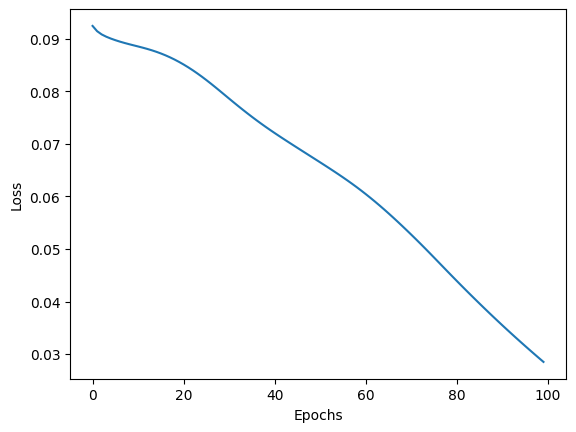

In [77]:
losses = net.fit(train_X, train_y)

plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [78]:
def evaluate(x, y):
    y = y.cpu().detach().numpy()
    y_hat = net.predict(x)
    print(f'Accuracy: {np.mean(y_hat == y)}')

    cm = confusion_matrix(y.cpu(), y_hat.cpu())
    cm_display = ConfusionMatrixDisplay(cm.cpu())
    cm_display.plot(cmap='Blues')
    plt.show()


In [79]:
print("Evaluating on train set")
evaluate(train_X, train_y)
print("Evaluating on train set")
evaluate(test_X, test_y)

Evaluating on train set
Accuracy: 0.8859166666666667


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [80]:
hessian = compute_hessian(net, nn.MSELoss(), train_X, nn.functional.one_hot(train_y.to(torch.int64), num_classes=10).to(torch.float32))

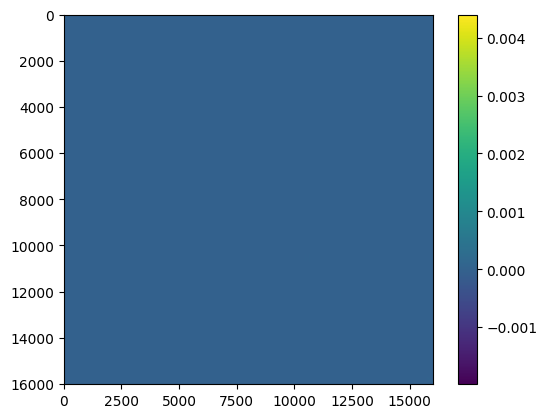

In [81]:
plt.imshow(hessian.detach().numpy())
plt.colorbar()


In [82]:
hessian.max(), hessian.min()

(tensor(0.0044), tensor(-0.0020))

In [83]:
eigenvalues = np.linalg.eigvals(hessian)
# print(list(eigenvalues))

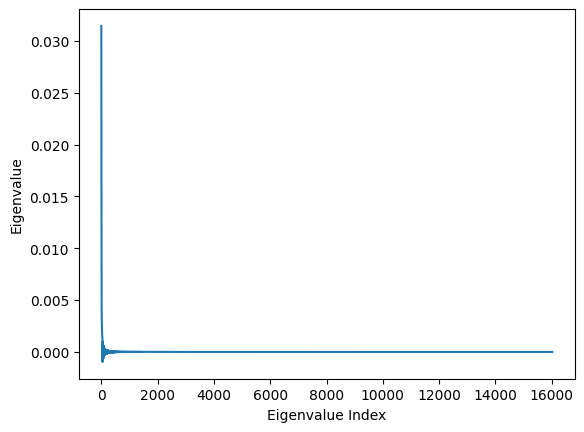

In [85]:
plt.plot(eigenvalues)
plt.xlabel('Eigenvalue Index')
plt.ylabel('Eigenvalue')
plt.show()


In [87]:
eigenvalues[eigenvalues > 1e-3].shape

(46,)